# TELIA 2024 Kodutöö-Klientide käitumise ennustamine ning muudatusettepanekud selle vältimiseks

Antud Notebooki eesmärgiks on ennustada klientide käitumist, et selle põhjal implementeerida muudatusi nende 
hoidmiseks. Selleks, et mudelit ehitada järgin järgmisi samme:

### 1.Esmalt Töötlen andmed.
    *Kontrollin puuduvate väärtuste olemasolu
    *Konverteerin kategoorilised andmed numbrilisteks (nt one-hot encoding)
    *Normaliseerin või skaleerin vajadusel pidevad (continuous) muutujad.
### 2.Teiseks teostan üsna eksploratiivse uuriva andmeanalüüsi.
    *Analüüsin võtmetunnuste ja muutujate jaotust.
    *Tuvastan seosed tunnuste ja kliendi lahkumise määra vahel, et leida potentsiaalseid ennustajaid.
    *Visualiseerin need erinevad mustrid, et paremini andmetest aru saada.
### 3.Kolmandaks loon uued tunnused.
    *Tunnuste loomisel lähtun sellest, millised põhjused võivad olla olulised kliendi lahkumise ennustamiseks.
### 4.Neljandaks otsustan, milline mudel on kõige mõistlikum kasutamiseks.
    *Selleks valin sobivad algoritmid kliendi lahkumise ennustamise mudeliks 
     (näiteks logistiline regressioon, decision tree, random tree, gradient boosting vms).
    *Jaotan andmestiku treening- ja testsettideks, et valideerida mudeli sooritust.
    *Treenin mudelit treeningkomplekti peal.   
### 5.Mudeli hindamine
    *Hindan mudeli võimekust erinevate meetrikate alusel (nt täpsus, recall, precision, AUCi kõver vms)
### 6.Mudeli optimeerimine
    Kui tulemused tunduvad kas liiga head (nt: kui täpsus on 100 siis toimub overfittimine) või ei õpi piisavalt,   siis optimeerin mudelit.
    *Selleks on mitu varianti. Esimene variant oleks lihtsalt mudelit uuesti optimeerida parameetritega.
    *Teine varaint oleks kasutada erinevaid tehnikaid nagu grid search või random search et leida optimaalseid
    hüpermarameetreid mudeli jaoks. Samuti on võimalik lihtsalt erinevaid mudeleid kombineerides ehitada ansambel mudel või proodiva võimekuse parandamiseks näiteks XGBoosti. Seda millist lähenemist antud töös praktsieerin, otsustan optimeerimise käigus.
### 7.Tõlgendan tulemused
    
Kuigi kondikava on sellega laiaslaastus sellega paigas, siis võib konkreetseid etappe läbides ühtteist 
muutuda.


# # 1.Andmete töötlemine

In [79]:
import pandas as pd

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Andmete laadimine
failitee = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
andmed = pd.read_csv(failitee)

#Puuduvate väärtuste kontroll
puuduvad_väärtused = andmed.isnull().sum()

#'TotalCharges' veeru teisendamine numbriliseks ja puuduvate väärtuste asendamine mediaaniga
andmed['TotalCharges'] = pd.to_numeric(andmed['TotalCharges'], errors='coerce')
andmed['TotalCharges'].fillna(andmed['TotalCharges'].median(), inplace=True)

# Kategooriliste veergude one-hot kodeerimine
kategoorilised_veerud = andmed.select_dtypes(include=['object']).columns.drop(['customerID', 'Churn'])
andmed_kodeeritud = pd.get_dummies(andmed, columns=kategoorilised_veerud)

#Sihtmärgi muutuja 'y' ja tunnuste 'X' eraldamine
y = andmed['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
X = andmed_kodeeritud.drop(['customerID', 'Churn'], axis=1)

andmed_kodeeritud.head()

#Samuti tekkis one-hot encodingu käigus kolm "uut" binaarset atribuuti: Contract_month_to_month, Contract_One year ja Contract_Two year.
#Lisaks kaks uut PaperlessBilling atribuuti ning neli erinevat PaymentMethod atribuuti.

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,No,True,False,False,True,...,False,True,False,False,False,True,False,False,True,False
1,5575-GNVDE,0,34,56.95,1889.50,No,False,True,True,False,...,False,False,True,False,True,False,False,False,False,True
2,3668-QPYBK,0,2,53.85,108.15,Yes,False,True,True,False,...,False,True,False,False,False,True,False,False,False,True
3,7795-CFOCW,0,45,42.30,1840.75,No,False,True,True,False,...,False,False,True,False,True,False,True,False,False,False
4,9237-HQITU,0,2,70.70,151.65,Yes,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False


Tundub, et ühtegi errorit ei ole!

# # 2.Uuriv andmeanalüüs

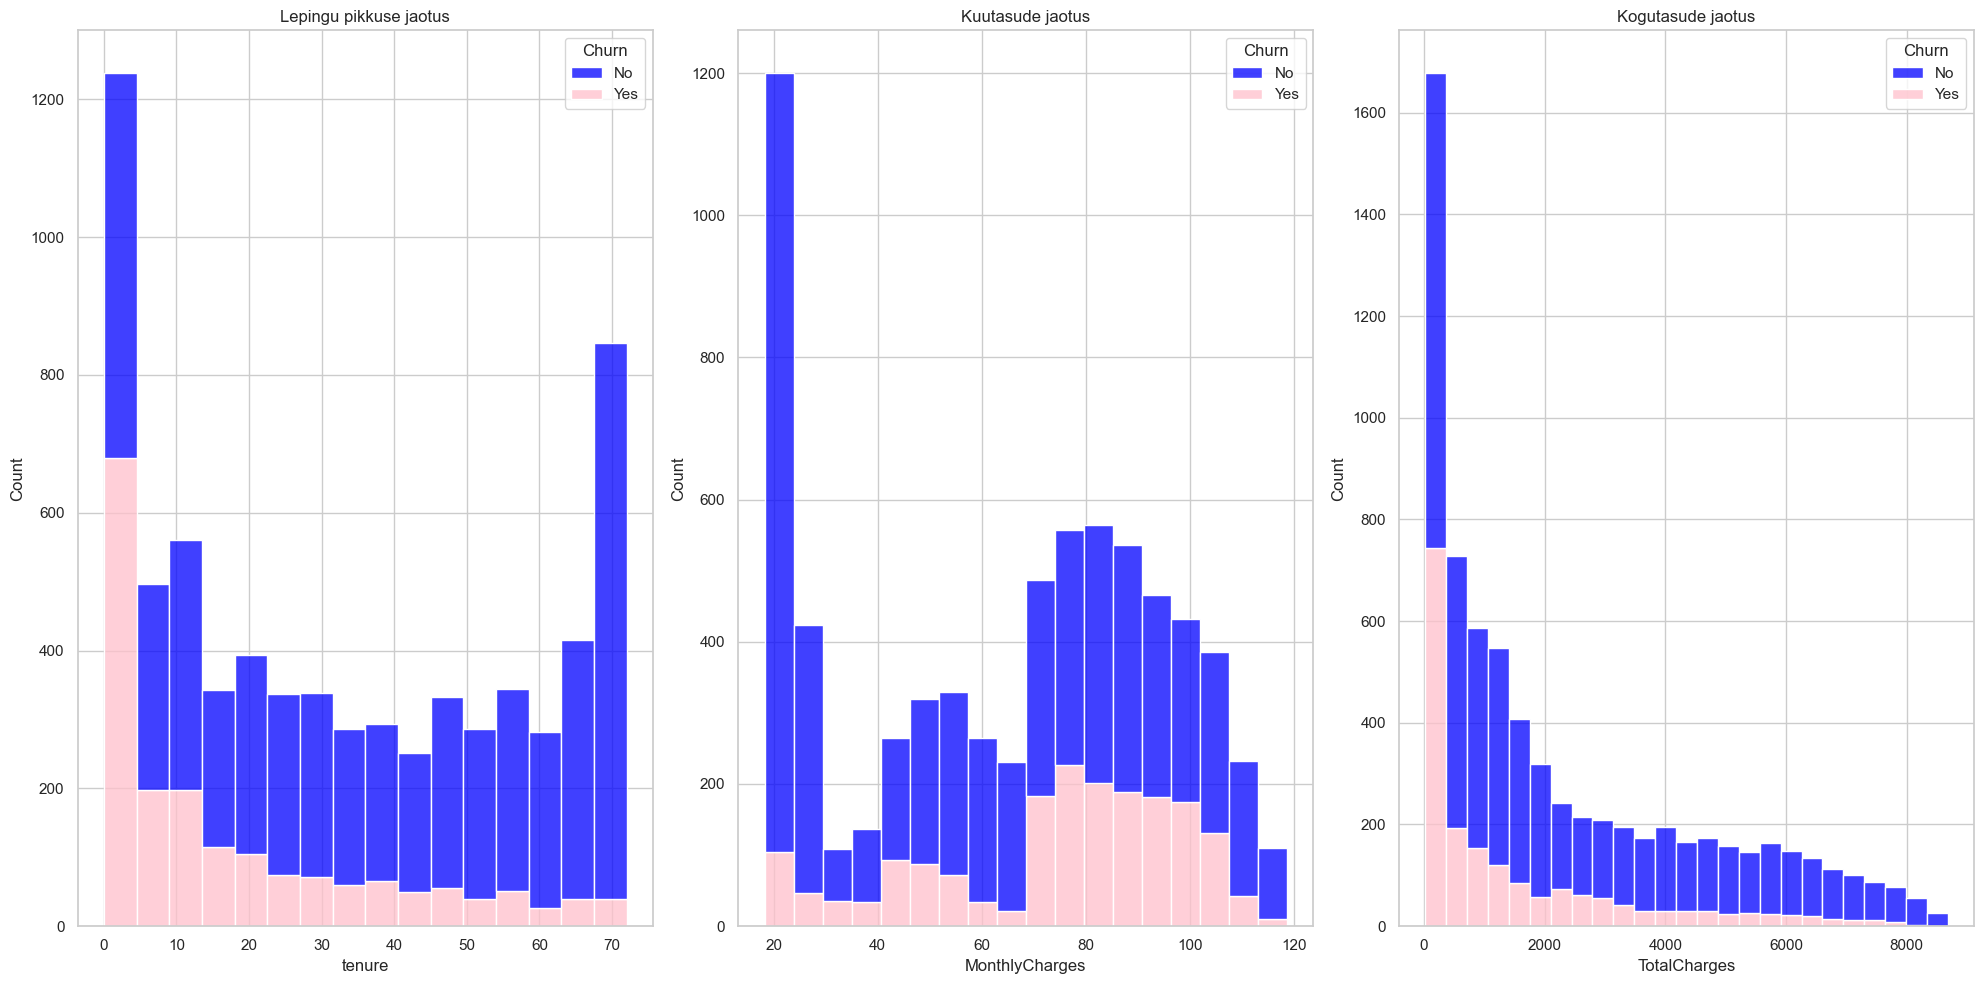

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

#Seadistan graafikute visuaalse stiili
sns.set(style="whitegrid")

#Analüüsin sihtmärgi muutuja 'Churn' jaotust
churn_distribution = andmed['Churn'].value_counts(normalize=True)

#Analüüsin võtmetähtsusega numbrilisi tunnuseid seoses kliendi lahkumisega
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

#Esmalt joonistan 'tenure' jaotuse graafiku. PS Tenure tähistab siin kliendiks olemise perioodi
#Kutsume seda antud graafikul "Lepingu pikkuseks"
sns.histplot(data=andmed, x='tenure', hue='Churn', multiple="stack", ax=axes[0], palette=['blue', 'pink'])
axes[0].set_title('Lepingu pikkuse jaotus')

#Seejärel 'MonthlyCharges' jaotuse graafiku
sns.histplot(data=andmed, x='MonthlyCharges', hue='Churn', multiple="stack", ax=axes[1], palette=['blue', 'pink'] )
axes[1].set_title('Kuutasude jaotus')

#Viimasena kuvan ka 'TotalCharges' jaotuse graafiku
sns.histplot(data=andmed, x='TotalCharges', hue='Churn', multiple="stack", ax=axes[2], palette=['blue', 'pink'])
axes[2].set_title('Kogutasude jaotus')

plt.tight_layout()
plt.show()

print(churn_distribution)




Üleval olevalt pildilt on näha, et Churn jaotuse oõhjal on umbes 26,5% klientidest lahkunud ja 73,5% alles jäänud.

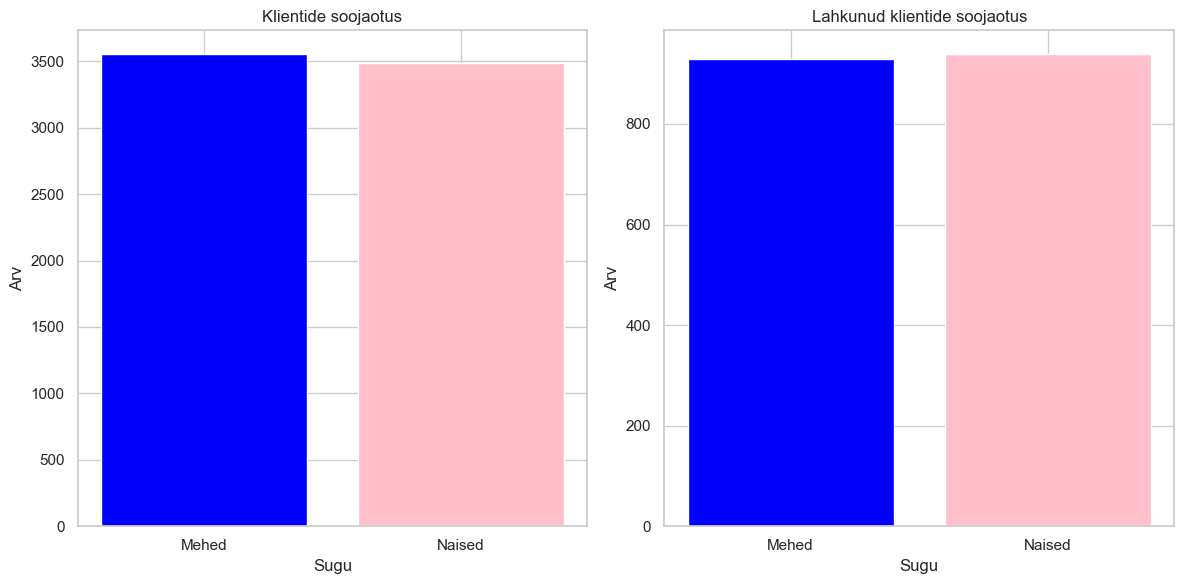

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

#Siin arvutan, mitu meest ja naist andmestikus on
meeste_arv = andmed[andmed['gender'] == 'Male'].shape[0]
naiste_arv = andmed[andmed['gender'] == 'Female'].shape[0]

#Arvutan, mitu meest ja naist on lahkunud
lahkunud_meeste_arv = andmed[(andmed['gender'] == 'Male') & (andmed['Churn'] == 'Yes')].shape[0]
lahkunud_naiste_arv = andmed[(andmed['gender'] == 'Female') & (andmed['Churn'] == 'Yes')].shape[0]

#Visualiseerin tulemused
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#Esimene graafik kõigi klientide soojaotuse kohta
ax[0].bar(['Mehed', 'Naised'], [meeste_arv, naiste_arv], color=['blue', 'pink'])
ax[0].set_title('Klientide soojaotus')
ax[0].set_ylabel('Arv')
ax[0].set_xlabel('Sugu')

#Teine graafik lahkunud klientide soojaotuse kohta
ax[1].bar(['Mehed', 'Naised'], [lahkunud_meeste_arv, lahkunud_naiste_arv], color=['blue', 'pink'])
ax[1].set_title('Lahkunud klientide soojaotus')
ax[1].set_ylabel('Arv')
ax[1].set_xlabel('Sugu')

plt.tight_layout()
plt.show()

Nagu graafikult näha, siis on meeste ja naiste osakaal andmestikus üsna võrdne. Samuti paistab et lahkujate soojaotus meeste ja naiste vahel on samuti üsna võrdne. Kuna sellega saime esmase pildi andmestikust kätte, asume andmeid ettevalmistama.

# # 3.Tunnusinseneeria ja andmete ettevalmistus

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split

#One-hot encoding: teisendan kõik kategoorilised tunnused numbrilisteks
#Eelnevalt määran sihtmäära 'y' ja eemaldan selle andmetest
y = andmed['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
andmed_without_churn = andmed.drop(['Churn'], axis=1)

#Rakendan one-hot encodingu kodeerimist kõikidele kategoorilistele tunnustele, välja arvatud 'customerID', mis ei vaja kodeerimist
andmed_encoded = pd.get_dummies(andmed_without_churn.drop(['customerID'], axis=1))

#Nüüd, kui 'Churn' on eemaldatud ja ülejäänud andmed kodeeritud, eraldan omadused
X = andmed_encoded

#Jagan andmestiku treening- ja testimiskomplektideks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Kontrollime kindluse mõttes andmestruktuurid üle, et seal ei oleks mingeid vigu.
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5634, 45) (1409, 45) (5634,) (1409,)


Outputist tundub, et andmed on kenasti jaotatud treening-ning testsettideks.

# # 4.Mudeli valimine ja treenimine

In [45]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Kontrollin lõpmatuid väärtusi ja asendan need NaN-idega
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

#Seejärel täidan need NaN-id veeru keskmise (või mediaani) väärtusega
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
skaleerija = StandardScaler()
X_train_scaled = skaleerija.fit_transform(X_train)
X_test_scaled = skaleerija.transform(X_test)

#Nüüd selle plokiga määran, et jätkataks mudeli treenimist kasutades skaleeritud andmeid
mudel = RandomForestClassifier(random_state=42)
mudel.fit(X_train_scaled, y_train)

#Testin mudelit
y_pred = mudel.predict(X_test_scaled)

#Hindan mudeli sooritust
täpsus = accuracy_score(y_test, y_pred)
aruanne = classification_report(y_test, y_pred)
segadusmaatriks = confusion_matrix(y_test, y_pred)

print('Mudeli täpsus:', täpsus)
print('Klassifikatsiooniaruanne:\n', aruanne)
print('Segadusmaatriks:\n', segadusmaatriks)


Mudeli täpsus: 0.7963094393186657
Klassifikatsiooniaruanne:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.48      0.55       373

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409

Segadusmaatriks:
 [[944  92]
 [195 178]]


Kuigi üleüldine täpsus on mudelil hea, siis mudeli tundlikkus (recall) on lahkuvate klientide puhul 48%, mis tähendab, et rohkem kui pool lahkuvatest klientidest suudeti õigesti tuvastada. Järgnevalt proovin aga RandomForest mudelit parendada, muutes treenimissügavust väiksemaks, et teha mudelit natuke lihtsamaks. Samuti lisan ka täpsete puude arvu. Kui sellest endiselt ei piisa, siis katsetan edasi paremate mudelitega (nt ansambli mudeli (ensemble) või XGBoosti algoritmiga)

# # 5.Mudeli tuunimine

In [46]:
mudel_tuned = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
mudel_tuned.fit(X_train_scaled, y_train)

#Tuunitud mudeli testimine
y_pred_tuned = mudel_tuned.predict(X_test_scaled)
täpsus_tuned = accuracy_score(y_test, y_pred_tuned)
aruanne_tuned = classification_report(y_test, y_pred_tuned)
confusionmatrix_tuned = confusion_matrix(y_test, y_pred_tuned)

print('Täiustatud mudeli täpsus:', täpsus_tuned)
print('Täiustatud klassifikatsiooniaruanne:\n', aruanne_tuned)
print('Täiustatud segadusmaatriks:\n', confusionmatrix_tuned)

Täiustatud mudeli täpsus: 0.8062455642299503
Täiustatud klassifikatsiooniaruanne:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.67      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Täiustatud segadusmaatriks:
 [[935 101]
 [172 201]]


Juba parem, kuid endiselt on recall võrdlemisi madal. Kuna selle aspekti eenustmis täpsus on antud töö juures oluline, siis ei saa antud mudeliga rahul olla ning katsetame edasi! Järgmiseks proovin tulemusi parendada ansambli mudeliga, mis koosneb logistilisest regressioonist, randomforestist ja gradient_boostingust.

In [63]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Initsialiseerin individuaalsed mudelid
logistiline_regressioon = LogisticRegression(random_state=42)
randomforest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)

#Loon mudelite ansambli (ingl k ensemble)
hääletus_klassifikaator = VotingClassifier(estimators=[
    ('lr', logistiline_regressioon), ('rf', randomforest), ('gbc', gradient_boosting)],
    voting='soft')

#Treenin ansambli mudelit
eclf.fit(X_train_scaled, y_train)

#Teen ennustused testkomplekti peal
y_pred_ensemble = eclf.predict(X_test_scaled)

#Sellega taaskord hindan ansambli mudeli sooritust
täpsus_ansambel = accuracy_score(y_test, y_pred_ensemble)
aruanne_ansambel = classification_report(y_test, y_pred_ensemble)
conf_matrix_ansambel = confusion_matrix(y_test, y_pred_ensemble)

print('Ansambli mudeli täpsus:', accuracy_ensemble)
print('Ansambli klassifikatsiooniaruanne:\n', report_ensemble)
print('Ansambli segadusmaatriks:\n', conf_matrix_ensemble)

Ansambli mudeli täpsus: 0.8161816891412349
Ansambli klassifikatsiooniaruanne:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.70      0.54      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.75      1409
weighted avg       0.81      0.82      0.81      1409

Ansambli segadusmaatriks:
 [[947  89]
 [170 203]]


Samuti jääb ka siin recall väga madalaks. Olles erinevaid mudeleid ja lähenemisi proovinud (osasid katsetusi ei pidanud vajalikuks kuvada ja alles jätta notebooki) on antud mudel neist kõigist täpseim (täpsus on 82%). See tulemus viitab sellele, et mudel on suhteliselt hea kliendi lahkumise ennustamisel. Klassifikatsiooniaruande kohaselt oli mudeli täpsus (precision) mitte-lahkuvate klientide puhul 85% ja lahkuvate klientide puhul 70%, näidates, et mudel oli usaldusväärsem ennustamisel, kui klient ei lahku. Kuid mudeli tundlikkus oli lahkuvate klientide puhul 54%, mis tähendab, et ligi pool lahkuvatest klientidest suudeti õigesti tuvastada. Võttes arvesse ülesande püstitust on see, aga endiselt kahjuks üsna kesine tulemus ning seetõttu proovin rakendada paremat mudelit. Selleks kasutan XGBoosti, mis on efektiivne keeruliste mustrite ja tasakaalust väljas andmete puhul. Samuti on XGBoosti üks peamisi tugevusi selle kõrge ennustustäpsus võrreldes paljude teiste traditsiooniliste masinõppe mudelitega. 

In [60]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Initsialiseerin XGBoost klassifikaatori kohandades positiivse klassi kaalu
xgb = XGBClassifier(scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss', random_state=42)

#Treenin mudelit skaleeritud treeningandmetega
xgb.fit(X_train_scaled, y_train)

# Teen ennustused skaleeritud testimiskomplekti peal
y_pred_xgb = xgb.predict(X_test_scaled)

#Hindan XGBoost mudeli täpsust
täpsus_xgb = accuracy_score(y_test, y_pred_xgb)
aruanne_xgb = classification_report(y_test, y_pred_xgb)
segadusmaatriks_xgb = confusion_matrix(y_test, y_pred_xgb)

#Väljastan mudeli võimekuse snäitajad
print(f'XGBoost mudeli täpsus: {täpsus_xgb}')
print(f'XGBoost klassifikatsiooniaruanne:\n{aruanne_xgb}')
print(f'XGBoost segadusmaatriks:\n{segadusmaatriks_xgb}')

XGBoost mudeli täpsus: 0.7757274662881476
XGBoost klassifikatsiooniaruanne:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1036
           1       0.56      0.71      0.62       373

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409

XGBoost segadusmaatriks:
[[830 206]
 [110 263]]


Tundlikkus on tõusnud 54% pealt 71% peale, mis tähendab, et mudel on nüüd palju parem lahkuvate klientide tuvastamisel.

Kuigi mudeli üldine täpsus on langenud, siis on minu arvates hetkel tundlikkuse (recall) suurenemine väärtuslikum arvestades, et hetkel on antud ülesande püstituseks oluline tuvastada klientide lahkumispõhjuseid.

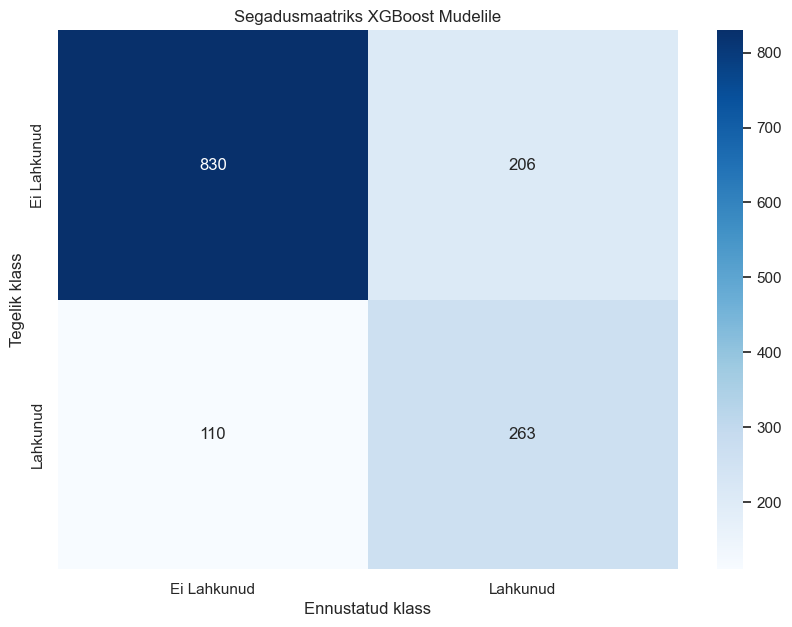

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Maatriksi väärtused
tn, fp, fn, tp = 830, 206, 110, 263

#Loon maatriksi (confusion matrix)
conf_matrix = np.array([[tn, fp], [fn, tp]])

#Siin ma loon vastavalt telgedele maatriksi näitlikustamaks tulemused
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ei Lahkunud', 'Lahkunud'], 
            yticklabels=['Ei Lahkunud', 'Lahkunud'])
plt.ylabel('Tegelik klass')
plt.xlabel('Ennustatud klass')
plt.title('Segadusmaatriks XGBoost Mudelile')
plt.show()



Siin on ka visualiseeritud confusion maatriksil eelnevas jutuplokis väljatoodud statistika.

# # 6.Tulemuste raporteerimine

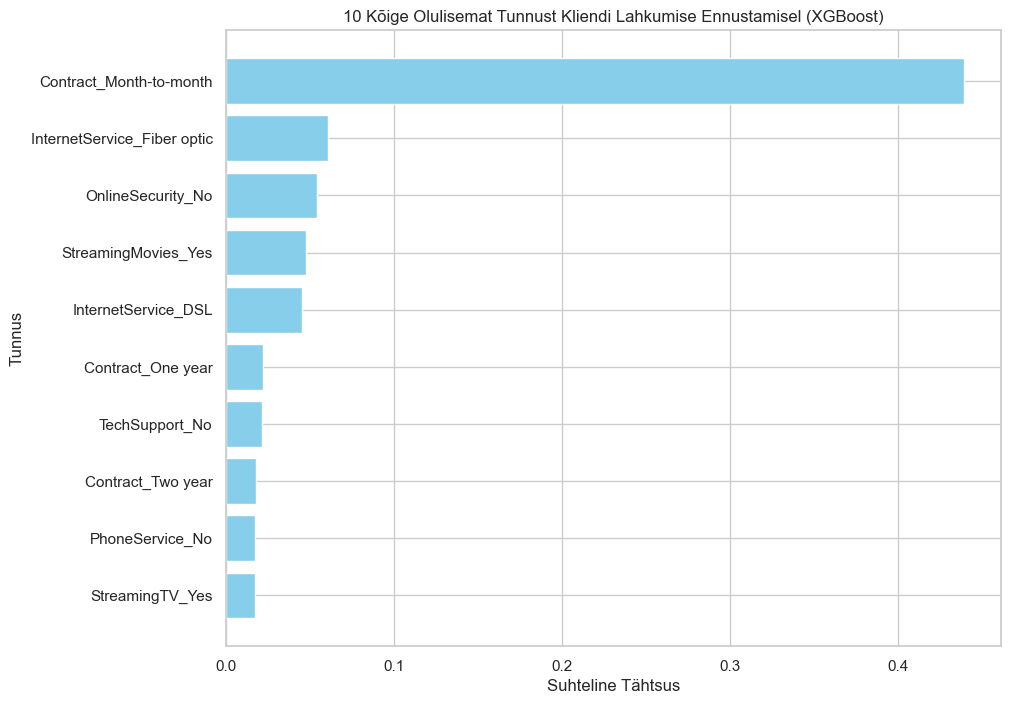

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss', random_state=42)

#Treenin mudelit kasutades skaleeritud treeningandmeid
xgb.fit(X_train_scaled, y_train)

#Võtan tunnuste tähtsused XGBoost mudelist
tunnuste_tähtsused = xgb.feature_importances_

#Loon andmestruktuuri tunnuste nimede ja nende tähtsuste jaoks
tunnused = X_train.columns
tähtsuse_df = pd.DataFrame({'Tunnus': tunnused, 'Tähtsus': tunnuste_tähtsused})

#Sorteerin DataFrame'i tähtsuse alusel kahanevalt
tähtsuse_df_sorteeritud = tähtsuse_df.sort_values(by='Tähtsus', ascending=False)

#Joonistan graafiku 10 kõige tähtsamale tunnusele
plt.figure(figsize=(10, 8))
plt.barh(tähtsuse_df_sorteeritud['Tunnus'][:10], tähtsuse_df_sorteeritud['Tähtsus'][:10], color='skyblue')
plt.xlabel('Suhteline Tähtsus')
plt.ylabel('Tunnus')
plt.title('10 Kõige Olulisemat Tunnust Kliendi Lahkumise Ennustamisel (XGBoost)')
plt.gca().invert_yaxis()  #See on selleks, et kuvada suurim tähtsus üleval
plt.show()


# KOKKUVÕTE

Graafikul kuvatud funktsioonide tähtsus viitab sellele, et "Kuutasu lepingu" tüüp on kõige olulisem tunnus kliendi lahkumise ennustamisel. See järgneb kliendi püsivusele (tenure), mis näitab, kui kaua klient on teenust kasutanud. Muud olulised tunnused hõlmavad "Kogukulud" ja "Kuutasud", mis viitavad sellele, et finantsfaktorid on lahkumise ennustamisel olulised. Vähem olulised, kuid siiski märkimisväärsed tunnused hõlmavad "Online Turvalisuse puudumist", "Kiudoptilist internetiteenust" ja "Tehnilise toe puudumist".


Järeldusena saame öelda, et kliendisäilituse strateegiate kujundamisel tuleks erilist tähelepanu pöörata lepingutingimustele, pakkudes paindlikkust või soodustusi klientidele, kes valivad kuutasu lepingu asemel pikemaajalise lepingu. Samuti peaksid teenusepakkujad pakkuma konkurentsivõimelisi hindu ja täiustama online turvalisuse ning tehnilise toe funktsioone, et vähendada klientide lahkumise tõenäosust.

### Tänud lugemast!